# Transformada Z - Filtros digitales en tiempo real

Usaremos el concepto de transformada Z (Expacio discreto Z) para discretizar la función de transferencia de un filtro de primer orden en tiempo continuo (Espacio de Laplace). La discretización nos permite implementar un filtro en código, con las ventajas en flexibilidad, depuración, disminución en fallos.

* Descripción matemática del proceso de discretización del filtro continuo
* Adquicisión de datos por el puerto serial e implementación del filtro en tiempo real

In [1]:
from IPython.display import Image
import serial
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from time import time
import re

%matplotlib notebook

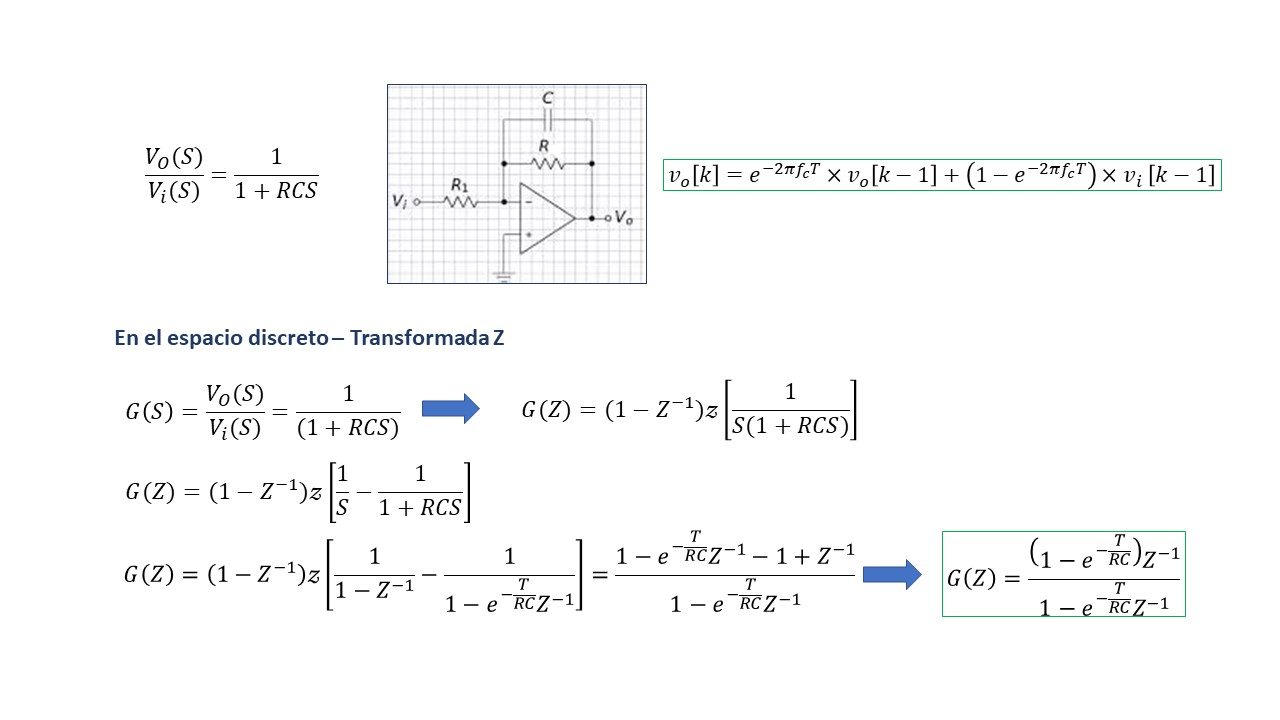

In [2]:
Image(filename='assets/FiltroD1.jpg')

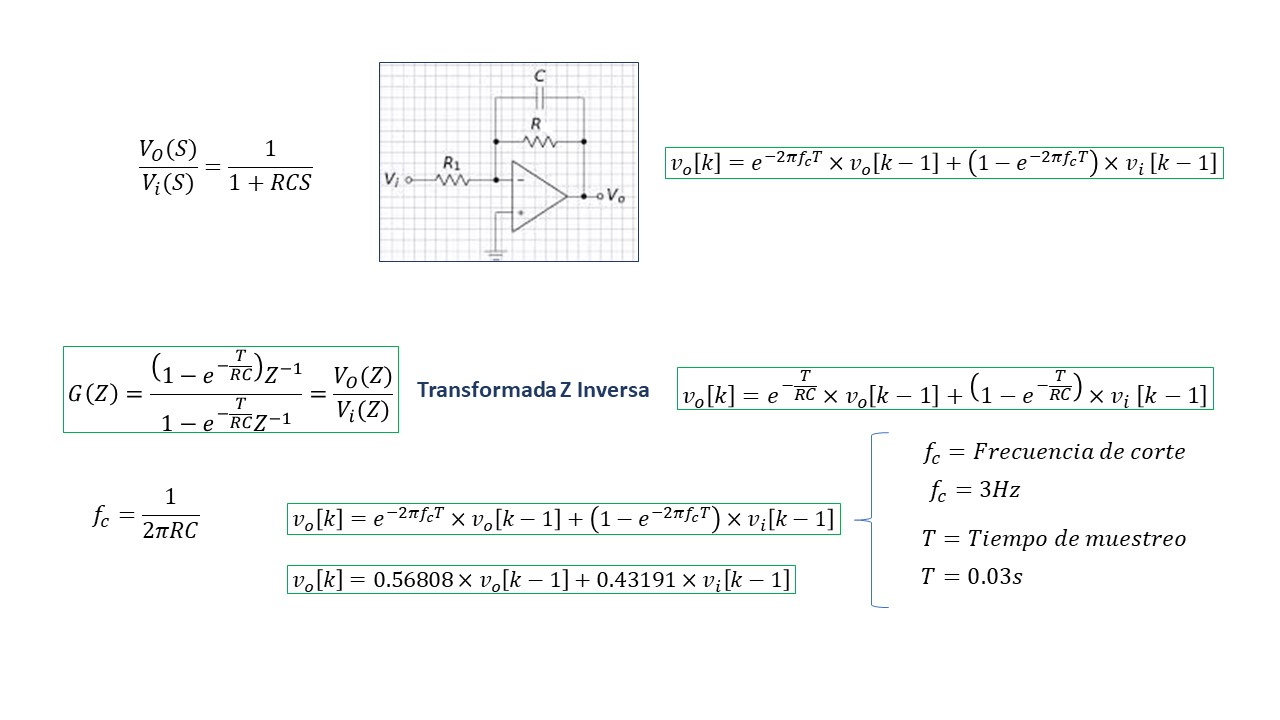

In [3]:
Image(filename='assets/FiltroD2.jpg')

## Implementación

Definimos las condiciones iniciales.

* vok representa la señal filtrada en un tiempo t-1
* vik representa la señal sin filtrar en un tiempo t-1

In [4]:
# Filtro de primer orden
vok = 0
vik = 0

#Filtro de tercer orden

vok3=0
vok2=0
vok1=0
vik3=0
vik2=0
vik1=0


Realizamos la adquisición por el puerto serial, luego implementamos el filtro digital (ecuación en recurrencia o ecuación en diferencias) y finalmente mostramos la señal filtrada y sin filtrar

<IPython.core.display.Javascript object>


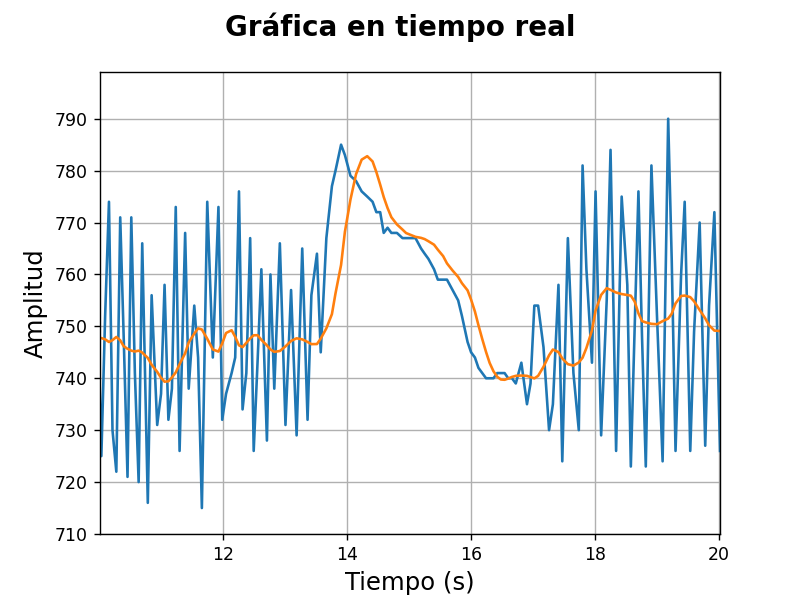

D:\Programas\miniconda3\envs\MiEntorno\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


In [15]:
# Iniciamos comunicación serial
com_ser = serial.Serial('/COM3', 230400)
com_ser.flushInput()

# Configuración en la visualización
VentanaTiempo = 10   # Define la ventana de tiempo que si visualiza en tiempo real
TiempoFinal = 20    # Define el tiempo total de adquisición 

# Configuración de la figura
plt.ion() 
figura1 = plt.figure()
figura1.suptitle('Gráfica en tiempo real', fontsize='16', fontweight='bold')
plt.xlabel('Tiempo (s)', fontsize='14')
plt.ylabel('Amplitud', fontsize='14')
plt.axes().grid(True)

# Lista para guardar datos Tiempo y Amplitud
timepoints = []
ydata = []
filtrado = []

# Configuración de la curva
line1, = plt.plot(ydata, linestyle='-')
line2, = plt.plot(ydata, linestyle='-')

plt.xlim([0,VentanaTiempo])

run = True
start_time = time()


while run:
    com_ser.reset_input_buffer()
    data = str(com_ser.readline()) # Lectura del puerto

    # El envío se realiza con un marcador $, sólo si la trama tiene ese marcador se separará los datos de la trama
    if(len(data.split('$'))>=2):
        data_sp=data.split('$')[1].split('\\r\\n')[0]

    try:
        # Agregamos los datos de amplitud y tiempo a cada lista
        
        # Dato recibido del sensor
        sensor = float(data_sp)
        
        # FILTRO DIGITAL 1ER ORDEN
        #vo=0.56801*vok+0.43191*vik;
        #vok=vo;
        #vik=float(sensor);
        #
        
        # FILTRO DIGITAL 3ER ORDEN. Fc=3 Hz. Fs = 33.33 Hz
        vo=1.881483426*vok1-1.309460391*vok2+0.3173878886*vok3+0.01382363442*sensor+0.04147090325*vik1+0.04147090325*vik2+0.01382363442*vik3;
        
        vok3=vok2
        vok2=vok1
        vok1=vo
        
        vik3=vik2
        vik2=vik1
        vik1=sensor
        #

        # Se asignan los datos a las listas para graficar
        ydata.append(sensor)
        filtrado.append(vo)
        timepoints.append(time()-start_time)
        current_time = timepoints[-1]
        
        # Se actutaliza los datos en la grafica 
        line1.set_xdata(timepoints)
        line1.set_ydata(ydata)
        
        # Se actutaliza los datos en la grafica 
        line2.set_xdata(timepoints)
        line2.set_ydata(filtrado)
        
        plt.ylim([min(ydata)-5,max(ydata)+5])
        # Se actualiza la ventan de observación de la gráfica
        if current_time > VentanaTiempo:
            plt.xlim([current_time-VentanaTiempo,current_time])
            
        # La ejecución termina cuando el tiempo de ejecución llega al límite
        if timepoints[-1] > TiempoFinal: run=False
    
    except: pass
    
    # Actualiza la gráfica
    figura1.canvas.draw()

# Cierra el puerto serial
com_ser.close()   

## Visualización off-line

<IPython.core.display.Javascript object>


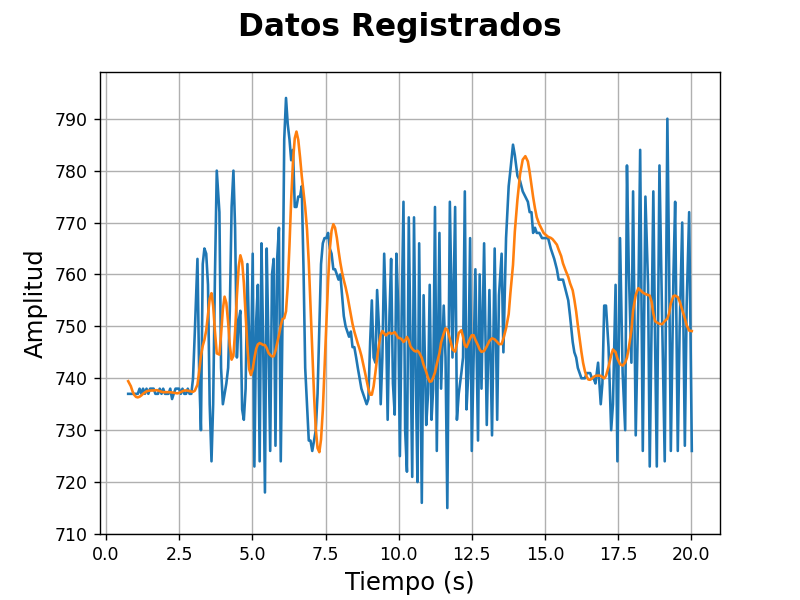

D:\Programas\miniconda3\envs\MiEntorno\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


In [16]:
figura2 = plt.figure()
figura2.suptitle('Datos Registrados', fontsize='18', fontweight='bold')

plt.xlabel('Tiempo (s)', fontsize='14')
plt.ylabel('Amplitud', fontsize='14')
plt.axes().grid(True)

plt.plot(timepoints, ydata,linestyle='-')
plt.plot(timepoints, filtrado,linestyle='-')

plt.ylim([min(ydata)-5,max(ydata)+5])
figura2.show()

## Grabar datos filtrados

In [12]:
datos= {'Tiempo':timepoints,'Amplitud':filtrado}
df = pd.DataFrame(datos)
df.to_csv('5.data/DatosRegistrados.csv', index=False)